# Predicting used cars prices in the Canadian market

When it comes to shopping for a used car, budget is one of the main constraints. Prices can differ for a variety of factors, and the experience is quite different than buying a new vehicle. The search process is the first step, and thanks to the internet, the buyer has access to a wealth of information and reviews. With all that said, there is virtually no way to know if an offer is **fair** or **overpriced**. In practice, *prior experience* and *extensive search* can help. How about using machine learning and data analysis to simplify the process and provide **unbiased** advice to the shopper?  
In the following notebook, I will design and present two machine learning algorithms that will predict used car prices in Canada. The same process could be followed to obtain similar prediction software for the US market.  
 First, an exploratory data analysis (EDA) will be performed on a dataset that will be downloaded from **Kaggle**. In the second step, features will be engineered to train and tune two different machine learning regression algorithms.  
 This project is part of the [Zero to Data Science Bootcamp by Jovian](https://jovian.ai/learn/zero-to-data-analyst-bootcamp).

## 1- Download used cars market data  
In this section, we will install and import all the libraries that will be used throughout the notebook. After that, a large dataset of used cars listings (from Canada and the US) will be downloaded. We will focus on the canadian data, but similar approach can be used to explore the listings from the US.

In [1]:
# download and import the libraries

!pip install opendatasets pandas numpy matplotlib seaborn tqdm sklearn --quiet
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
import opendatasets as od
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

The library `OpenDataSets` by **Jovian** is a conveniant tool to get data from Kaggle. It requires a username and password from the account.

In [2]:
# download data
filepath = '.\\data\\marketcheck-automotive-data-us-canada'
url = 'https://www.kaggle.com/rupeshraundal/marketcheck-automotive-data-us-canada?select=ca-dealers-used.csv'
if not(os.path.exists(filepath)):
    od.download_kaggle_dataset(url, filepath)    

This will download two seperate `csv` files. Let's explore the `ca-dealers-used.csv` file using `Pandas`.

In [3]:
# read csv data 
canada_ds = pd.read_csv(filepath+'\\ca-dealers-used.csv', low_memory=False)
canada_ds.head(3) 

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4


Each transaction is detailled through multiple columns. The `VIN` number is unique to each car. This field will be used later to remove duplicates. Let's show the properties for each column.

In [4]:
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393603 entries, 0 to 393602
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            393603 non-null  object 
 1   vin           393603 non-null  object 
 2   price         358486 non-null  float64
 3   miles         366590 non-null  float64
 4   stock_no      365929 non-null  object 
 5   year          393586 non-null  float64
 6   make          393603 non-null  object 
 7   model         388809 non-null  object 
 8   trim          354824 non-null  object 
 9   body_type     359578 non-null  object 
 10  vehicle_type  355365 non-null  object 
 11  drivetrain    354608 non-null  object 
 12  transmission  357922 non-null  object 
 13  fuel_type     322790 non-null  object 
 14  engine_size   320950 non-null  float64
 15  engine_block  320439 non-null  object 
 16  seller_name   391371 non-null  object 
 17  street        385674 non-null  object 
 18  city

It appears that some columns lack informations for a certain number of transactions. 

In [5]:
canada_ds.isna().sum()

id                  0
vin                 0
price           35117
miles           27013
stock_no        27674
year               17
make                0
model            4794
trim            38779
body_type       34025
vehicle_type    38238
drivetrain      38995
transmission    35681
fuel_type       70813
engine_size     72653
engine_block    73164
seller_name      2232
street           7929
city             7774
state            7836
zip              7769
dtype: int64

We choose to drop all the rows missing pieces of information since we still will have a sufficient amount of data. Before that, we will drop all the columns that won't be used.

In [6]:
unused_columns = ['id', 'stock_no','seller_name', 'street','trim','engine_size', 
                'zip','body_type','fuel_type', 'engine_block','vehicle_type']
canada_ds.drop(unused_columns,axis = 1, inplace=True)
canada_ds.dropna(inplace=True)

Then, we remove all duplicates using the same `vin` number.

In [7]:
canada_ds.drop_duplicates('vin', inplace=True)
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172605 entries, 0 to 393602
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           172605 non-null  object 
 1   price         172605 non-null  float64
 2   miles         172605 non-null  float64
 3   year          172605 non-null  float64
 4   make          172605 non-null  object 
 5   model         172605 non-null  object 
 6   drivetrain    172605 non-null  object 
 7   transmission  172605 non-null  object 
 8   city          172605 non-null  object 
 9   state         172605 non-null  object 
dtypes: float64(3), object(7)
memory usage: 14.5+ MB


The resulting data frame contains more than 172000 records, with no duplicate and no missing fields. Let's display more details about the column `state`.

In [8]:
#fix state information
canada_ds.state.unique()

array(['NB', 'QC', 'BC', 'ON', 'AB', 'MB', 'SK', 'NS', 'PE', 'NL', 'SC',
       'OH', 'YT', 'NC'], dtype=object)

`OH`, `NC` and `SC` do not represent canadian provinces. To fix this problem, we display the `city` values.

In [9]:
canada_ds[canada_ds['state']=='OH']['city'].unique()

array(['Woodbridge'], dtype=object)

After some search, it turns out that *Woodbridge* is a city in Ontario. We just have to replace the values in the data frame. 

In [10]:
canada_ds['state'].replace('OH','ON',inplace=True)

We proceed the same way with `SC` and `NC`. We found that `NC` doesn't contain any record in a canadian city, and `SC` contains records in **Quebec city, QC**.

In [39]:
canada_ds.drop(index = canada_ds[canada_ds.state=='NC'].index, inplace=True)
canada_ds['state'].replace('SC','QC',inplace=True)

The column `year` provides the model year of the car. 

In [12]:
canada_ds['year'].describe()

count    172590.000000
mean       2016.351399
std           3.256696
min        1981.000000
25%        2015.000000
50%        2017.000000
75%        2019.000000
max        2022.000000
Name: year, dtype: float64

The data is a snapshot of the listings in 2021, with some cars labeled as from year 2022. This is a common practice in the automotive industry, known as the **model year**. We could create a column `age` using the data from `year`.

In [13]:
# create Age column 
canada_ds['age'] = 2022- canada_ds['year'] 

One last improvment to our data is to remove outliers, but limiting the age, price and mileage of cars.

In [14]:
# filter very expensive and very old cars (outliers)
canada_ds=canada_ds[canada_ds['age']<25]
canada_ds=canada_ds[canada_ds['price']<100000]
canada_ds=canada_ds[canada_ds['miles']<200000]
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165660 entries, 16 to 393599
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           165660 non-null  object 
 1   price         165660 non-null  float64
 2   miles         165660 non-null  float64
 3   year          165660 non-null  float64
 4   make          165660 non-null  object 
 5   model         165660 non-null  object 
 6   drivetrain    165660 non-null  object 
 7   transmission  165660 non-null  object 
 8   city          165660 non-null  object 
 9   state         165660 non-null  object 
 10  age           165660 non-null  float64
dtypes: float64(4), object(7)
memory usage: 15.2+ MB


## 2- Exploratory Data Analysis

In this section, we will display some graphs to get an intuition about the data that will be used to design the prediction algorithms.

C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


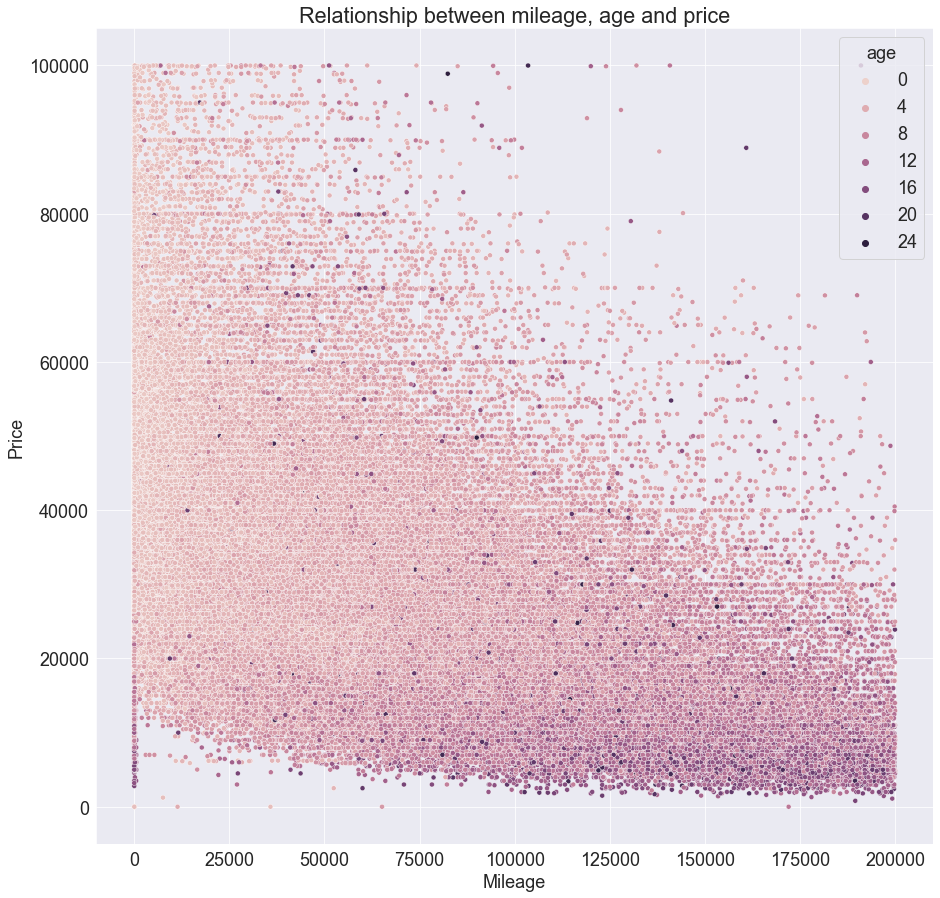

In [17]:
matplotlib.rcParams['figure.figsize'] = (15, 15)
fig = sns.scatterplot(y ='price',x='miles', hue = 'age',data =canada_ds,s=25);
fig.set(xlabel = 'Mileage', ylabel = 'Price', title = 'Relationship between mileage, age and price');

It appears that expensive cars are either recent or have low mileage. There are some exceptions (consider the dark points) where some old cars can hold a high value, regardless of the mileage.  
This next graphs show the most expensive, and the less expensive car makes in the market.

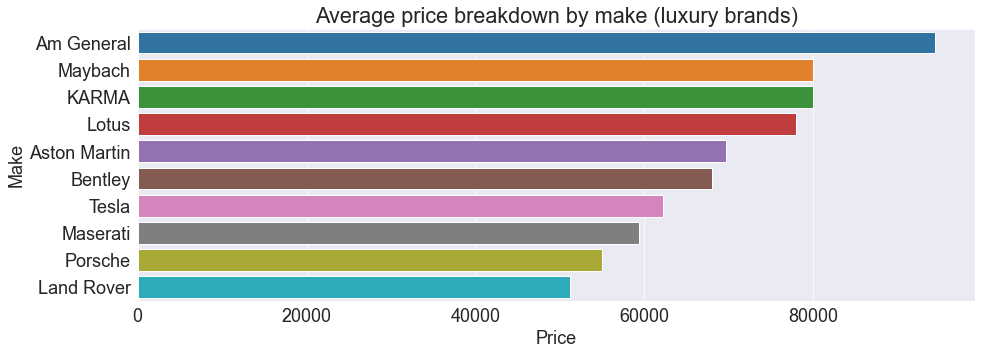

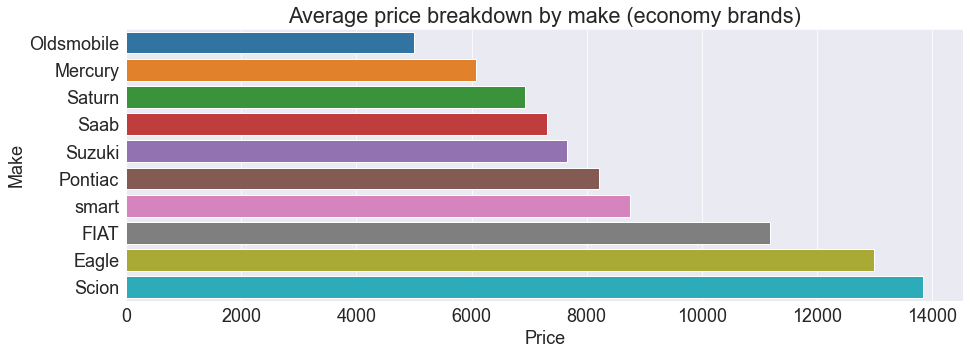

In [22]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (luxury brands)');
plt.figure()
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=True).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (economy brands)');

Let's explore which drivetrain is more common in Canada.

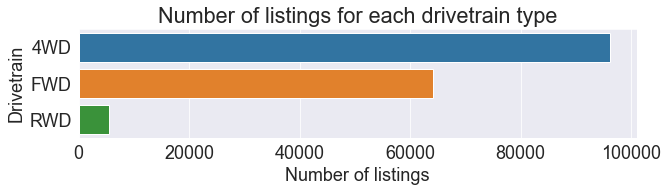

In [30]:
matplotlib.rcParams['figure.figsize'] = (10, 2)
column = 'drivetrain'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Drivetrain', title = 'Number of listings for each drivetrain type');

With no surprise, `4wd` cars are very common in Canada, due to its well-known winter!  
The next graph will show how `Automatic` transmissions are more prefered in the canadian market.

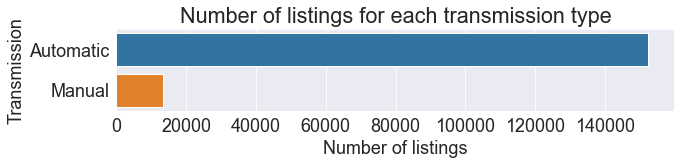

In [37]:
matplotlib.rcParams['figure.figsize'] = (10, 1.5)
column = 'transmission'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Transmission', title = 'Number of listings for each transmission type');

Used vehicles are more expensive in some provinces, due to standard of living, taxes and emission control. This is shown in the next graph.

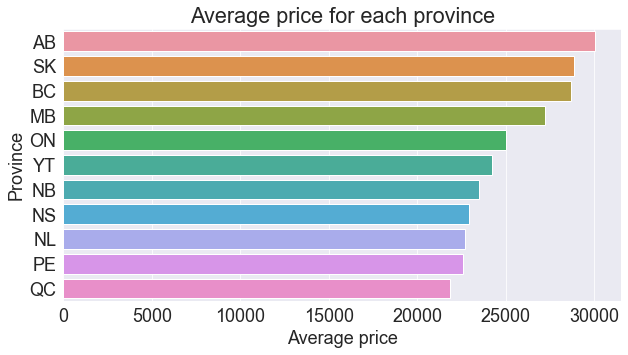

In [43]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Average price', ylabel = 'Province', title = 'Average price for each province');

The market share of each provice is related to its population size. As we show on the next plot, Ontario has the highest number of listings (and the largest population).

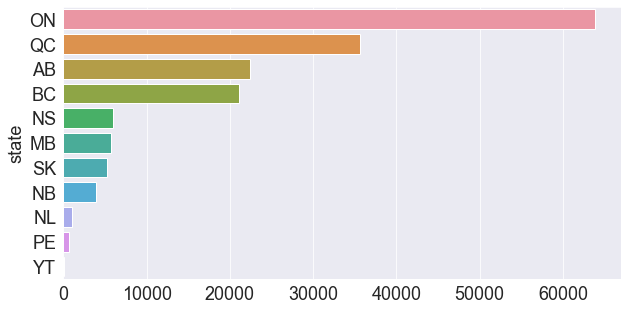

In [44]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);

## 3- Prepare data for machine learning

missing: car condition

In [50]:
target_cols = ['price']
features_num_cols = ['miles', 'age',]
features_cat_cols = ['make', 'model', 'drivetrain', 'transmission','state', 'city']

In [51]:
raw_data = canada_ds[features_num_cols+features_cat_cols+target_cols].copy()

In [52]:
# split train, test and val
# remove annoying warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import train_test_split
trainval_data, test_data = train_test_split(raw_data, test_size = 0.2)
train_data, val_data = train_test_split(trainval_data, test_size = 0.25)

In [53]:
# normalize numeric inputs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data[features_num_cols])
train_data[features_num_cols] = scaler.transform(train_data[features_num_cols])
test_data[features_num_cols] = scaler.transform(test_data[features_num_cols])
val_data[features_num_cols] = scaler.transform(val_data[features_num_cols])


In [54]:
# one hot encoding categorical inputs
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_data[features_cat_cols])
new_one_hot_cols = list(encoder.get_feature_names(features_cat_cols))
train_data[new_one_hot_cols] = encoder.transform(train_data[features_cat_cols])
test_data[new_one_hot_cols] = encoder.transform(test_data[features_cat_cols])
val_data[new_one_hot_cols] = encoder.transform(val_data[features_cat_cols])

In [55]:
print('number of features ={}'.format(len(features_num_cols + new_one_hot_cols)))

number of features =1546


In [56]:
# create input and output dataframes
train_inputs = train_data[features_num_cols + new_one_hot_cols]
test_inputs = test_data[features_num_cols + new_one_hot_cols]
val_inputs = val_data[features_num_cols + new_one_hot_cols]

train_output = train_data[target_cols]
test_output = test_data[target_cols]
val_output = val_data[target_cols]

In [60]:
print('output average ={:.2f}$'.format(train_output.mean().values[0]))

output average =25538.17$


## 4- Predicting the price using machine learning 

### 4-1 Regression using XGBoost

In [ ]:
#first attempt XGBoost 

from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor 

In [ ]:
#tune param max_depth
n_init = 5
results=[]
for max_depth in tqdm(range(5,51,5)):
    model = XGBRegressor(n_estimators = n_init, max_depth = max_depth)
    model.fit(train_inputs, train_output)
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)
    error_train = mean_squared_error(train_output, train_preds, squared=False)
    error_val = mean_squared_error(val_output, val_preds, squared=False)
    print('max_depth = {}'.format(max_depth),"error_train = {:.2f} *** error_val = {:.2f}".format(error_train,error_val))
    results.append([max_depth,error_train, error_val, model])

In [ ]:
params = [results[i][0] for i in range(len(results))]
T_e = [results[i][1] for i in range(len(results))]
V_e = [results[i][2] for i in range(len(results))]
plt.plot(params, V_e, 'r');
plt.plot(params, T_e, 'g');
# 40 seems to be the sweet spot

In [ ]:
# tune param n_estimators
max_depth_opt = 40
results =[]
for n_estimators in tqdm(range(10,61,5)):
    model = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth_opt)
    model.fit(train_inputs, train_output)
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)
    error_train = mean_squared_error(train_output, train_preds, squared=False)
    error_val = mean_squared_error(val_output, val_preds, squared=False)
    print('n_estimators = {}'.format(n_estimators),"error_train = {:.2f} *** error_val = {:.2f}".format(error_train,error_val))
    results.append([n_estimators, error_train, error_val, model])

In [ ]:
params = [results[i][0] for i in range(len(results))]
T_e = [results[i][1] for i in range(len(results))]
V_e = [results[i][2] for i in range(len(results))]
plt.plot(params, V_e, 'r');
plt.plot(params, T_e, 'g');

### 4-2 Regression using neural networks

In [ ]:
# neural network
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

network = models.Sequential()
network.add(layers.Dense(2000 , activation='relu' , input_dim=len(features_num_cols + new_one_hot_cols))) 
network.add(layers.Dense(2000 , activation='relu')) 
network.add(layers.Dense(1)) 

network.compile(optimizer='adam', loss='MeanSquaredError', metrics=['RootMeanSquaredError'])

# Training 
n_epochs =2000
result = network.fit(train_inputs, train_output,epochs = n_epochs,verbose=1, batch_size = 10000,
                     validation_data=(val_inputs,val_output),callbacks = [es])

## 5- Conclusion and future work